In [2]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import json
from itertools import chain, product, permutations
from collections import defaultdict
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, BRICS
from krxns.cheminfo import expand_unpaired_cofactors, mcs, draw_molecule, draw_reaction
from krxns.config import filepaths
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import entropy
from IPython.display import display, SVG
from tqdm import tqdm
print(rdkit.__version__)

2024.03.2


In [3]:
# Load known reaction data
with open(filepaths['data'] / "sprhea_240310_v3_mapped.json", 'r') as f:
    known_reactions = json.load(f)

known_reactions = {int(k): v for k,v in known_reactions.items()}

# Extract known compounds
known_compounds = {}
for elt in known_reactions.values():
    subs = chain(*[side.split(".") for side in elt['smarts'].split(">>")])
    for sub in subs:
        known_compounds[sub] = elt['smi2name'].get(sub, None)

known_compounds = {i: {'smiles': k, 'name': v} for i, (k, v) in enumerate(known_compounds.items())}
smi2id = {v['smiles']: k for k, v in known_compounds.items()}

# Remove reverses
rids = set()
for k, v in known_reactions.items():
    rids.add(tuple(sorted([k, v['reverse']])))

keepers = [elt[0] for elt in rids]

known_reactions = {k: known_reactions[k] for k in keepers}
print(len(known_reactions))

9801


In [125]:
# Load cofactors

k = 10

paired_fp = filepaths['data_cofactors'] / "paired_cofactors_reference.tsv"
unpaired_fp = filepaths['data_cofactors'] / "unpaired_cofactors_reference.tsv"
name_blacklist = [
    'acetyl-CoA',
    'CoA'
]

unpaired_ref = pd.read_csv(
    filepath_or_buffer=unpaired_fp,
    sep='\t'
)

filtered_unpaired = unpaired_ref.loc[~unpaired_ref['Name'].isin(name_blacklist), :]

cofactors = expand_unpaired_cofactors(filtered_unpaired, k=k)

manual = {
    '[Fe+2]': 'Fe2+',
    '[Fe+3]': 'Fe3+',
    'N#N': 'N2',
    '[H][H]': 'H2',
    'S': 'hydrogen sufide'
}

cofactors = {**cofactors, ** manual}
cofactors

[17:48:32] WARNING: not removing hydrogen atom without neighbors


{'C#[O+]': nan,
 'O=C=O': 'CO2',
 'O=C(O)O': 'hydrogencarbonate',
 '[H+]': nan,
 'OO': 'H2O2',
 'Br': nan,
 'C#N': 'hydrogen cyanide',
 '[C-]#[NH+]': 'hydrogen cyanide',
 'Cl': nan,
 'F': nan,
 'I': nan,
 'N': 'NH4(+)',
 'O=O': 'O2',
 'O=P(O)(O)OP(=O)(O)O': 'diphosphate',
 'O=P(O)(O)O': 'phosphate',
 'O=S(=O)(O)O': 'sulfate',
 'O=S(O)O': 'sulfite',
 'O': 'H2O',
 '[Fe+2]': 'Fe2+',
 '[Fe+3]': 'Fe3+',
 'N#N': 'N2',
 '[H][H]': 'H2',
 'S': 'hydrogen sufide'}

In [126]:
# Create naive graph

G = nx.Graph()

G.add_nodes_from([(k, v) for k,v in known_compounds.items()])

for rid, rxn in known_reactions.items():
    lhs, rhs = [side.split(".") for side in rxn['smarts'].split(">>")]
    for pair in product(lhs, rhs):
        left_cid, right_cid = smi2id[pair[0]], smi2id[pair[1]]
        G.add_edge(left_cid, right_cid, **rxn)

print(G.number_of_nodes(), G.number_of_edges())

8777 28339


Demonstrate the problem with naively connecting all substrates that appear opposite one another in a reaction

In [127]:
nad_ids = {}
for id in known_compounds:
    name = known_compounds[id]['name']
    if name:
        if 'NAD' in name:
            nad_ids[name] = id
nad_ids

{'NADP(+)': 1,
 'NADPH': 4,
 'NADH': 47,
 'NAD(+)': 50,
 '(6S)-NADHX;(6R)-NADHX': 196,
 'deamido-NAD(+)': 210,
 "a 5'-end NAD(+)-phospho-ribonucleoside residue": 1276,
 '(6S)-NADPHX;(6R)-NADPHX': 1689,
 '1,2-dihydro-beta-NADP': 4071,
 '1,6-dihydro-beta-NAD': 4991,
 '1,2-dihydro-beta-NAD': 5010,
 '1,6-dihydro-beta-NADP': 7162}

In [128]:
print(G.nodes[47]['name'])
[(idx, G.nodes[idx]['name'], G.nodes[idx]['smiles']) for idx in G.neighbors(47)]

NADH


[(3565, '2,5-dihydroxybenzoate', 'O=C(O)c1cc(O)ccc1O'),
 (50,
  'NAD(+)',
  'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1'),
 (7, 'H2O', 'O'),
 (613, 'a 1,4-benzosemiquinone', '*c1c(*)c(O)c(*)c(*)c1[O]'),
 (2271, '(2R)-3-sulfolactate', 'O=C(O)C(O)CS(=O)(=O)O'),
 (2003, 'corticosterone', 'CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C(C(=O)CO)CCC12'),
 (5707, 'spermine monoaldehyde', 'NCCCNCCCCNCCC=O'),
 (2197, 'phylloquinol', 'CC(=CCc1c(C)c(O)c2ccccc2c1O)CCCC(C)CCCC(C)CCCC(C)C'),
 (3951,
  '7alpha,25-dihydroxycholesterol',
  'CC(CCCC(C)(C)O)C1CCC2C3C(O)C=C4CC(O)CCC4(C)C3CCC12C'),
 (1901, 'squalene', 'CC(C)=CCCC(C)=CCCC(C)=CCCC=C(C)CCC=C(C)CCC=C(C)C'),
 (37, 'diphosphate', 'O=P(O)(O)OP(=O)(O)O'),
 (2280,
  'lithocholoyl-CoA',
  'CC(CCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C1CCC2C3CCC4CC(O)CCC4(C)C3CCC12C'),
 (596, 'shikimate', 'O=C(O)C1=CC(O)C(O)C(O)C1'),
 (3114,
  'cis-4,5-dihydroxycyclohexa-2,6-diene-1,2-dic

In [129]:
corticosterone_nad = G.edges[47, 2003]
formate_nad = G.edges[47, 13]

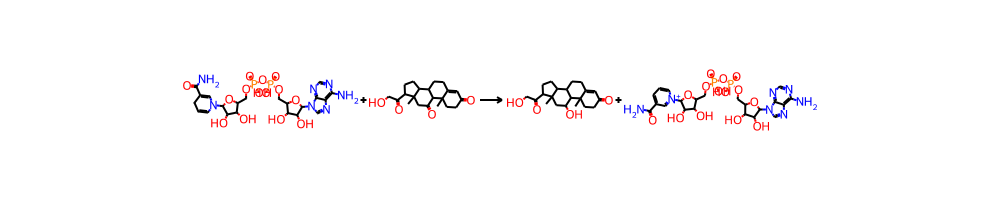

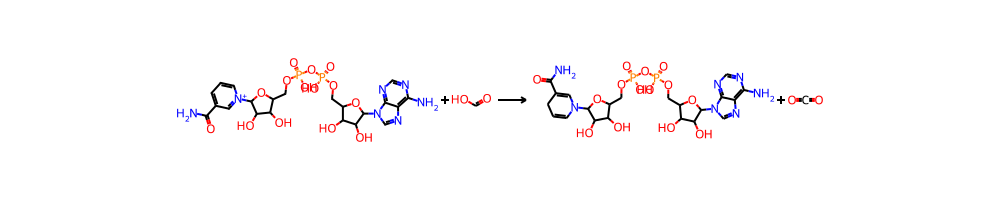

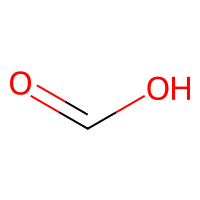

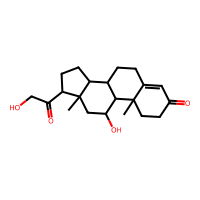

In [130]:
display(SVG(draw_reaction(corticosterone_nad['smarts'])))
display(SVG(draw_reaction(formate_nad['smarts'])))
formate = [v for v in known_compounds.values() if v['name'] == 'formate'][0]
display(SVG(draw_molecule(formate['smiles'])))
corticosterone = [v for v in known_compounds.values() if v['name'] == 'corticosterone'][0]
SVG(draw_molecule(corticosterone['smiles']))

Align reactants & products on a reaction-by-reaction basis

In [131]:
def filter_cofactors(known_reactions: dict[str, dict], cofactors: dict[str, str]):
    '''
    Filters cofactors out of known reaction dict
    '''    
    filtered_krs = {}
    for rid, rxn in known_reactions.items():
        lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
        lhs = sorted([elt for elt in lhs if elt not in cofactors])
        rhs = sorted([elt for elt in rhs if elt not in cofactors])

        if not lhs or not rhs:
            continue

        if len(lhs) > len(rhs):
            tmp = lhs
            lhs = rhs
            rhs = tmp

        filtered_krs[rid] = (lhs, rhs)
    
    return filtered_krs

def plot_side_counts(side_counts: dict[tuple, tuple]):
    x_labels, cts = zip(*sorted([(k, len(v)) for k,v in side_counts.items()], key= lambda x : x[1], reverse=True))
    x = np.arange(len(x_labels))

    fig, ax = plt.subplots()
    ax.bar(x, height=cts)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_ylabel("# reactions")
    ax.set_xlabel("(# reactants, # products)")
    plt.show()

def connect_reaction(rsms: dict[str, pd.DataFrame]):
    def get_partner(sim, candidates):
        sim /= sim.sum(axis=0).reshape(1, -1)
        H = entropy(sim, axis=0).reshape(-1,)
        midx = np.argmin(H)
        return candidates[np.argmax(sim[:, midx])]

    tmp_lid = set()
    tmp_rid = set()
    sim_block = []
    n_metrics = 0
    for k, v in rsms.items():
        tmp_lid.add(tuple(v.index))
        tmp_rid.add(tuple(v.columns))
        sim_block.append(v.to_numpy())
        n_metrics += 1

    if len(tmp_lid) > 1 or len(tmp_rid) > 1:
        raise ValueError("IDs from similarity matrices are not the same")
    else:
        lid = list(tmp_lid)[0]
        rid = list(tmp_rid)[0]
        sim_block = np.stack(sim_block, axis=-1)

    l_partners = {}
    for i, li in enumerate(lid):
        sim = sim_block[i, :, :].copy().reshape(-1, n_metrics)
        l_partners[li] = get_partner(sim, rid)

    r_partners = {}
    for j, rj in enumerate(rid):
        sim = sim_block[:, j, :].copy().reshape(-1, n_metrics)
        r_partners[rj] = get_partner(sim, lid)

    adj_mat = pd.DataFrame(
        data=np.zeros(shape=(len(lid), len(rid))),
        index=lid,
        columns=rid
    )
    
    for li, p in l_partners.items():
        adj_mat.loc[li, p] = 1

    for rj, p in r_partners.items():
        adj_mat.loc[p, rj] = 1

    return {"left": l_partners, "right": r_partners, "adj_mat": adj_mat}

def is_frustrated(rxn_sim_mat: pd.DataFrame):
    rxn_sim_mat = rxn_sim_mat.to_numpy()

    if rxn_sim_mat.shape[0] > rxn_sim_mat.shape[1]:
        rxn_sim_mat = rxn_sim_mat.T

    m, n = rxn_sim_mat.shape
    rct_partners = np.argmax(rxn_sim_mat, axis=1)
    pdt_partners = np.argmax(rxn_sim_mat, axis=0)
    partner_matches = [pdt_partners[rct_partners[i]] == i for i in range(len(rct_partners))]

    if sum(partner_matches) == m:
        return False
    else:
        return True


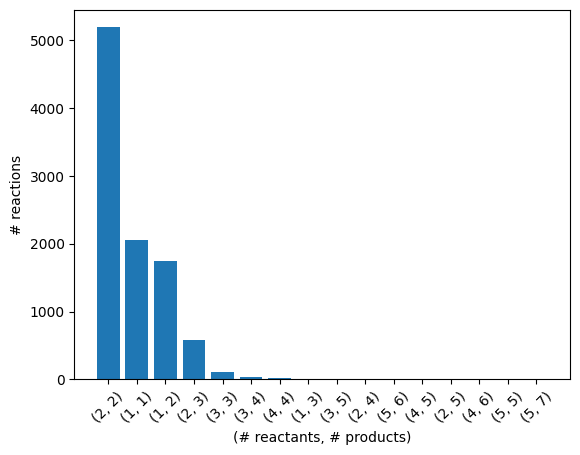

In [132]:
filtered_krs = filter_cofactors(known_reactions, cofactors)
side_counts = defaultdict(set)
for rid, (lhs, rhs) in filtered_krs.items():
    side_counts[tuple(sorted([len(x) for x in [lhs, rhs]]))].add(rid)
plot_side_counts(side_counts)

In [133]:
cpd_appears_in = defaultdict(set)

# Reaction co-appearance matrix (Jaccard)
cpd_corr = np.zeros(shape=(len(known_compounds), len(known_compounds)))
for rid, rxn in known_reactions.items():
    lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
    lhs = sorted([elt for elt in lhs if elt not in cofactors])
    rhs = sorted([elt for elt in rhs if elt not in cofactors])

    for elt in chain(lhs, rhs):
        cpd_appears_in[smi2id[elt]].add(rid)

    for pair in product(lhs, rhs):
        i, j = [smi2id[elt] for elt in pair]
        cpd_corr[i, j] += 1
        cpd_corr[j, i] += 1
    
row_sum = cpd_corr.sum(axis=1).reshape(-1, 1)
col_sum = cpd_corr.sum(axis=0).reshape(1, -1)
cpd_jaccard = cpd_corr / (row_sum + col_sum - cpd_corr) # Jaccard co-occurence-in-rxn index. Symmetric
cond_prob = cpd_corr / row_sum # elt (i, j) gives P(cpd_j | cpd_i). NOT symmetric

# Structural based sim mats
cpd_tani = np.load(filepaths['artifacts_sim_mats'] / "tanimoto.npy")
cpd_mcs = np.load(filepaths['artifacts_sim_mats'] / "mcs.npy")

# BRICS based assigment matrix (not currently used)
brics_mats = {}
brics_filepath = filepaths['artifacts_sim_mats'] / "brics"
for fn in brics_filepath.iterdir():
    rid = int(fn.stem)
    df = pd.read_csv(fn, sep='\t', index_col=0)
    brics_mats[rid] = df

# Consolidate sim mats
cc_sim_mats = {
    'mcs': cpd_mcs,
    'tanimoto': cpd_tani,
    'jaccard': cpd_jaccard,
}

# Count # rxns that cpds appear in
rxns_per_cpd = {k: len(v) for k, v in cpd_appears_in.items()}

/tmp/ipykernel_85573/1842203878.py:20: RuntimeWarning: invalid value encountered in divide
  cpd_jaccard = cpd_corr / (row_sum + col_sum - cpd_corr) # Jaccard co-occurence-in-rxn index. Symmetric
/tmp/ipykernel_85573/1842203878.py:21: RuntimeWarning: invalid value encountered in divide
  cond_prob = cpd_corr / row_sum # elt (i, j) gives P(cpd_j | cpd_i). NOT symmetric


In [134]:
id2jaccard = {}
for rid, rxn in known_reactions.items():
    lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
    lhs = sorted([elt for elt in lhs if elt not in cofactors])
    rhs = sorted([elt for elt in rhs if elt not in cofactors])
    for pair in product(lhs, rhs):
        ids = tuple(sorted([smi2id[elt] for elt in pair]))
        id2jaccard[ids] = cpd_jaccard[ids[0], ids[1]]

srt_cofactor_pairs = sorted(id2jaccard, key=lambda x : id2jaccard[x], reverse=True)
srt_jaccards = [id2jaccard[id] for id in srt_cofactor_pairs]

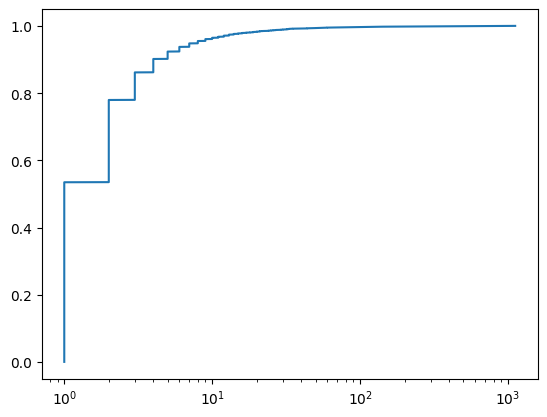

0.8990982764524598 4


In [135]:
ep = 1e-3
thresh = 0.9
srt_cpd_rxn_cts = sorted(rxns_per_cpd.values(), reverse=False)
cdf = np.arange(1, len(srt_cpd_rxn_cts) + 1) / len(srt_cpd_rxn_cts)
idx = np.where(abs(cdf - thresh) < ep)[0][0]
plt.plot(srt_cpd_rxn_cts, cdf)
plt.xscale('log')
plt.show()
print(cdf[idx], srt_cpd_rxn_cts[idx])

In [136]:
thresh = 30

[[known_compounds[id]['name'] for id in pair] for pair in srt_cofactor_pairs if all([rxns_per_cpd[id] > thresh for id in pair])]

[['FMNH2', 'FMN'],
 ['NADH', 'NAD(+)'],
 ['NADP(+)', 'NADPH'],
 ["adenosine 3',5'-bisphosphate", "3'-phosphoadenylyl sulfate"],
 ['FAD', 'FADH2'],
 ['A', 'AH2'],
 ['S-adenosyl-L-methionine', 'S-adenosyl-L-homocysteine'],
 ['2-oxoglutarate', 'succinate'],
 ['ADP', 'ATP'],
 ['GDP', 'GDP-beta-L-fucose'],
 ['UDP', 'UDP-alpha-D-glucose'],
 ['CMP', 'CMP-N-acetyl-beta-neuraminate'],
 ['pyruvate', 'L-alanine'],
 ['ATP', 'AMP'],
 ['glycine', 'glyoxylate'],
 ['UDP', 'UDP-N-acetyl-alpha-D-galactosamine'],
 ['CoA', 'acetyl-CoA'],
 ['oxaloacetate', 'L-aspartate'],
 ['L-serine', 'ethanolamine'],
 ['L-glutamate', '2-oxoglutarate'],
 ['UDP', 'UDP-alpha-D-glucuronate'],
 ['CoA', 'malonyl-CoA'],
 ['L-glutamate', 'L-glutamine'],
 ['GDP', 'GTP'],
 ['a 1,2-diacyl-sn-glycerol', 'a 1,2-diacyl-sn-glycero-3-phosphocholine'],
 ['a carboxylate', 'a fatty aldehyde'],
 ['FAD', 'chloride'],
 ['glutathione', 'glutathione'],
 ['succinyl-CoA', 'succinate'],
 ['cholesterol', '1-hexadecanoyl-sn-glycero-3-phosphocholine'

In [122]:
id = [elt for elt in known_compounds if known_compounds[elt]['name'] == 'hydrogen sulfide'][0]

eg = cpd_appears_in[id]

In [73]:
[cpd_appears_in[pair[0]] | cpd_appears_in[pair[1]] for pair in srt_cofactor_pairs]

[{16660},
 {6024},
 {11093},
 {9665},
 {16463},
 {4429},
 {13241},
 {8904},
 {14405, 16984},
 {13931, 17546},
 {15498},
 {7206},
 {41, 793},
 {4582},
 {13625},
 {13050},
 {2543},
 {8765},
 {12256},
 {7115},
 {9107},
 {20074},
 {4812},
 {10315, 12329},
 {2007},
 {8812},
 {14602},
 {3486},
 {6215},
 {5516},
 {13620},
 {11132},
 {15409},
 {15375},
 {1035},
 {1640},
 {5099, 20191},
 {6372, 8419},
 {34},
 {8718},
 {8041, 11454},
 {2501},
 {17860},
 {18806},
 {10222},
 {443},
 {9877},
 {11942},
 {16598},
 {6717},
 {13673},
 {4737},
 {12116},
 {4557},
 {3140, 7947},
 {10289},
 {14216},
 {16389},
 {10315, 12329},
 {1156},
 {5386, 13862},
 {199},
 {3096},
 {132, 3597},
 {19193},
 {6180},
 {7660},
 {13327},
 {2332},
 {5099, 20191},
 {13343},
 {6298},
 {3662},
 {9507, 10451},
 {12265},
 {10727},
 {6372, 8419},
 {6211},
 {1873},
 {1193},
 {15755},
 {2776},
 {4892},
 {14451},
 {17374},
 {4251},
 {18569},
 {14047},
 {3097, 7946},
 {1876, 2415, 15352, 17018},
 {10373},
 {8754},
 {559, 2484},
 {5659},

In [25]:
rxn_sim_mats = defaultdict(dict)
id_rsms = defaultdict(dict)
side_counts = defaultdict(set)
for rid, rxn in known_reactions.items():
    lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
    lhs = sorted([elt for elt in lhs if elt not in cofactors])
    rhs = sorted([elt for elt in rhs if elt not in cofactors])

    if not lhs or not rhs:
        continue

    if len(lhs) > len(rhs):
        tmp = lhs
        lhs = rhs
        rhs = tmp

    left_ids, right_ids = np.array([smi2id[smi] for smi in lhs]), np.array([smi2id[smi] for smi in rhs])
    left_names, right_names = [known_compounds[id]['name'] for id in left_ids], [known_compounds[id]['name'] for id in right_ids]


    # Add cpd sim mats
    i, j = np.array(list(zip(*product(left_ids, right_ids))))
    for k, cs in cc_sim_mats.items():
        data = cs[i, j].reshape(len(left_ids), len(right_ids))
        
        df = pd.DataFrame(data=data, columns=right_names, index=left_names)
        rxn_sim_mats[rid][k] = df

        df = pd.DataFrame(data=data, columns=right_ids, index=left_ids)
        id_rsms[rid][k] = df

    side_counts[tuple(sorted([len(x) for x in [lhs, rhs]]))].add(rid)


In [26]:
# Connect substrates reaction-by-reaction

rxn_cxn = {}
for rid, rsm in id_rsms.items():
    rxn_cxn[rid] = connect_reaction(rsm)

/tmp/ipykernel_85573/324122925.py:37: RuntimeWarning: invalid value encountered in divide
  sim /= sim.sum(axis=0).reshape(1, -1)


In [27]:
# Identify frustrated reactions

frustrated = set()
for rid, entry in rxn_cxn.items():

    if is_frustrated(entry['adj_mat']):
        frustrated.add(rid)

print(f"{len(frustrated)} / {len(rxn_cxn)} = {len(frustrated) / len(rxn_cxn) * 100 :.2f}%")

747 / 9778 = 7.64%


In [28]:
# Manually fix some common frustration patterns

manual_fix_pairs = [
    (68, 34), # AMP, ATP
    (324, 326), # A, AH2
    (31, 34), # ADP, ATP
    
]

for rid in frustrated:
    removed = []
    metrics = id_rsms[rid]
    processed_rsm = {}
    for m in metrics:
        df = metrics[m].copy()
        for pair in manual_fix_pairs:
            for perm in permutations(pair):
                if perm[0] in df.index and perm[1] in df.columns:
                    df.drop(labels=perm[0], inplace=True)
                    df.drop(columns=perm[1], inplace=True)
                    removed.append(perm)
                    processed_rsm[m] = df
    
    if removed:
        res = connect_reaction(processed_rsm)
        for l, r in removed:
            res['left'][l] = r
            res['right'][r] = l
            res['adj_mat'].loc[l, :] = 0
            res['adj_mat'].loc[:, r] = 0
            res['adj_mat'].loc[l, r] = 1

        rxn_cxn[rid] = res


/tmp/ipykernel_85573/324122925.py:37: RuntimeWarning: invalid value encountered in divide
  sim /= sim.sum(axis=0).reshape(1, -1)
/tmp/ipykernel_85573/324122925.py:37: RuntimeWarning: invalid value encountered in divide
  sim /= sim.sum(axis=0).reshape(1, -1)
/tmp/ipykernel_85573/324122925.py:37: RuntimeWarning: invalid value encountered in divide
  sim /= sim.sum(axis=0).reshape(1, -1)
/tmp/ipykernel_85573/324122925.py:37: RuntimeWarning: invalid value encountered in divide
  sim /= sim.sum(axis=0).reshape(1, -1)
/tmp/ipykernel_85573/324122925.py:37: RuntimeWarning: invalid value encountered in divide
  sim /= sim.sum(axis=0).reshape(1, -1)
/tmp/ipykernel_85573/324122925.py:37: RuntimeWarning: invalid value encountered in divide
  sim /= sim.sum(axis=0).reshape(1, -1)
/tmp/ipykernel_85573/324122925.py:37: RuntimeWarning: invalid value encountered in divide
  sim /= sim.sum(axis=0).reshape(1, -1)
/tmp/ipykernel_85573/324122925.py:37: RuntimeWarning: invalid value encountered in divide


In [29]:
# Re-identify frustrated reactions

frustrated = set()
for rid, entry in rxn_cxn.items():

    if is_frustrated(entry['adj_mat']):
        frustrated.add(rid)

print(f"{len(frustrated)} / {len(rxn_cxn)} = {len(frustrated) / len(rxn_cxn) * 100 :.2f}%")

497 / 9778 = 5.08%


In [30]:
# Any reactions with substrates unaccounted for?

mass_loss = set()
for rid, entry in rxn_cxn.items():
    adj = entry['adj_mat'].to_numpy()
    if (adj.sum(axis=0) == 0).any():
        mass_loss.add(rid)
    elif (adj.sum(axis=0) == 0).any():
        mass_loss.add(rid)

print(f"{len(mass_loss)} / {len(rxn_cxn)} = {len(mass_loss) / len(rxn_cxn) * 100 :.2f}%")

0 / 9778 = 0.00%


Spot check

In [31]:
def display_rxn_info(rid):
    sis = (300, 200) # sub img size
    for k in cc_sim_mats:
        print(k.upper())
        display(rxn_sim_mats[rid][k])

    adj = rxn_cxn[rid]['adj_mat'].copy()
    adj.columns = [known_compounds[elt]['name'] for elt in adj.columns]
    adj.index = [known_compounds[elt]['name'] for elt in adj.index]
    print("FINAL")
    display(adj)

    split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]

    for i, whitelist in enumerate(split_subs):
        data = [
            (Chem.MolFromSmiles(smi), known_compounds[smi2id[smi]]['name'])
            for smi in known_reactions[rid]['smi2name'] if smi in whitelist
        ]
        mols, names = zip(*data)
        mpr = len(mols)

        display(Draw.MolsToGridImage(mols=mols, legends=names, molsPerRow=mpr, subImgSize=sis))
        if i == 0:
            print(f"{'-' * 50}>")

In [32]:
options = sorted(frustrated)
frustrated_dropdown = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

interact(display_rxn_info, rid=frustrated_dropdown)

interactive(children=(Dropdown(description='Rxn ID:', options=(2, 40, 110, 155, 184, 187, 192, 221, 232, 283, …

<function __main__.display_rxn_info(rid)>

In [34]:
options = sorted([rid for rid in rxn_cxn if rid not in frustrated])
not_frustrated_dropdown = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

interact(display_rxn_info, rid=not_frustrated_dropdown)

interactive(children=(Dropdown(description='Rxn ID:', options=(0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16,…

<function __main__.display_rxn_info(rid)>

In [123]:
options = list(eg)
frustrated_dropdown = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

interact(display_rxn_info, rid=frustrated_dropdown)

interactive(children=(Dropdown(description='Rxn ID:', options=(12924, 7425, 1922, 6536, 11016, 1034, 11019, 52…

<function __main__.display_rxn_info(rid)>

In [124]:
known_reactions[7425]

{'smarts': 'NC(CCS)C(=O)O.O=C(O)CCC(=O)O>>S.NC(CCOC(=O)CCC(=O)O)C(=O)O',
 'min_rule': 'rule0196',
 'imt_rules': ['rule0196_1'],
 'smi2name': {'NC(CCS)C(=O)O': 'L-homocysteine',
  'O=C(O)CCC(=O)O': 'succinate',
  'NC(CCOC(=O)CCC(=O)O)C(=O)O': 'O-succinyl-L-homoserine',
  'S': 'hydrogen sulfide'},
 'enzymes': [{'uniprot_id': 'P9WGB4',
   'sequence': 'MTDESSVRTPKALPDGVSQATVGVRGGMLRSGFEETAEAMYLTSGYVYGSAAVAEKSFAGELDHYVYSRYGNPTVSVFEERLRLIEGAPAAFATASGMAAVFTSLGALLGAGDRLVAARSLFGSCFVVCSEILPRWGVQTVFVDGDDLSQWERALSVPTQAVFFETPSNPMQSLVDIAAVTELAHAAGAKVVLDNVFATPLLQQGFPLGVDVVVYSGTKHIDGQGRVLGGAILGDREYIDGPVQKLMRHTGPAMSAFNAWVLLKGLETLAIRVQHSNASAQRIAEFLNGHPSVRWVRYPYLPSHPQYDLAKRQMSGGGTVVTFALDCPEDVAKQRAFEVLDKMRLIDISNNLGDAKSLVTHPATTTHRAMGPEGRAAIGLGDGVVRISVGLEDTDDLIADIDRALS',
   'existence': 'Inferred from homology',
   'reviewed': 'reviewed',
   'ec': '2.5.1.-',
   'organism': 'Mycobacterium tuberculosis (strain CDC 1551 / Oshkosh)',
   'name': 'O-succinylhomoserine sulfhydrylase (OSH sulfhydrylase) (OSHS sulfh

Look at frustration metric by metric

In [35]:
frustrated = defaultdict(set)
for rid, metrics in rxn_sim_mats.items():
    for m, rsm in metrics.items():

        if is_frustrated(rsm):
            frustrated[m].add(rid)

for k,v in frustrated.items():
    print(f"{k}: {len(v)} / {len(rxn_sim_mats)}")

any_frustrated = set(frustrated['mcs']) | set(frustrated['jaccard']) | set(frustrated['tanimoto'])

print(f"Any (not brics) metric frustrated / total rxns: {len(any_frustrated)} / {len(rxn_sim_mats)}")

print(f"{len(set(frustrated['mcs']) ^ set(frustrated['jaccard']))} / {len(set(frustrated['mcs']) | set(frustrated['jaccard']))}")

mcs: 677 / 9778
tanimoto: 708 / 9778
jaccard: 727 / 9778
Any (not brics) metric frustrated / total rxns: 1402 / 9778
1110 / 1257


In [36]:
options = sorted(any_frustrated)
frustrated_metrics_dropdown = widgets.Dropdown(
    options=options,
    value=options[0],
    description="Rxn ID:",
    disabled=False
)

@interact
def display_frustrated(rid=frustrated_metrics_dropdown):
    sis = (300, 200) # sub img size
    for k in cc_sim_mats:
        print(f"{k.upper()} frustrated: {rid in frustrated[k]}")
        display(rxn_sim_mats[rid][k])

    split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]

    for i, whitelist in enumerate(split_subs):
        data = [
            (Chem.MolFromSmiles(smi), name)
            for smi, name in known_reactions[rid]['smi2name'].items() if smi in whitelist
        ]
        mols, names = zip(*data)
        mpr = len(mols)

        display(Draw.MolsToGridImage(mols=mols, legends=names, molsPerRow=mpr, subImgSize=sis))
        if i == 0:
            print(f"{'-' * 50}>")

interactive(children=(Dropdown(description='Rxn ID:', options=(2, 24, 38, 40, 42, 43, 44, 47, 54, 69, 89, 98, …

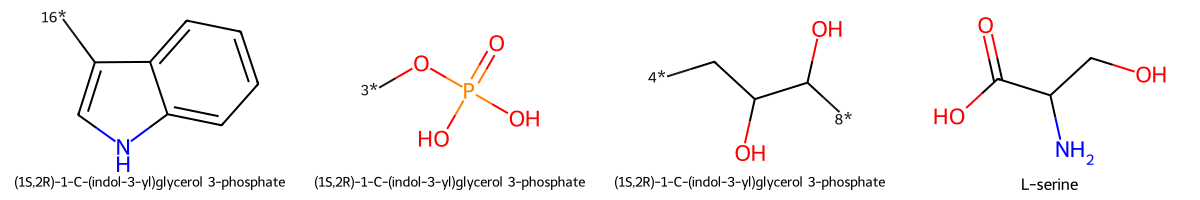

-------------------------------------------------->


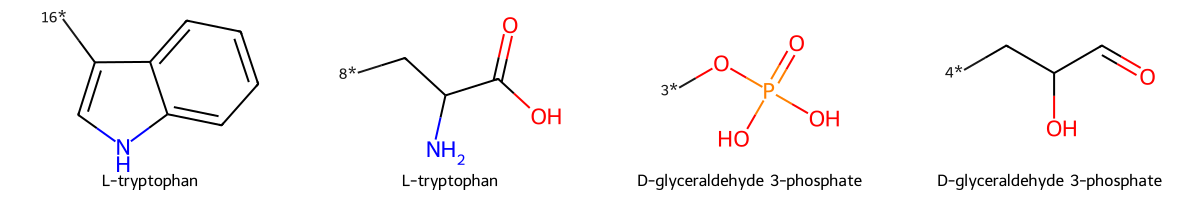

In [37]:
rid = 110
sis = (300, 200)
split_subs = [elt.split(".") for elt in known_reactions[rid]['smarts'].split(">>")]
for i, side in enumerate(split_subs):
    frags = []
    frag_names = []
    for smi in side:
        if smi in cofactors:
            continue

        name = known_reactions[rid]['smi2name'][smi]
        mol = Chem.MolFromSmiles(smi)
        new_frags = [Chem.MolFromSmiles(elt) for elt in BRICS.BRICSDecompose(mol)]
        frags += new_frags
        frag_names += [name for _ in range(len(new_frags))]
    
    display(Draw.MolsToGridImage(frags, molsPerRow=len(frags), legends=frag_names, subImgSize=sis))

    if i == 0:
        print(f"{'-' * 50}>")

Miscellaneous

In [38]:
# CoA reactions study

coa_rxns = {}
for k, v in known_reactions.items():
    for name in v['smi2name'].values():
        if name is None:
            continue

        if 'CoA' in name:
            coa_rxns[k] = v
            break


unpaired_coa_rxns = {}
for k, v in coa_rxns.items():
    lhs_coa, rhs_coa = False, False
    rcts, pdts = [elt.split(".") for elt in v['smarts'].split(">>")]
    lhs_coa = any(['CoA' in  v['smi2name'][smi] for smi in rcts if v['smi2name'][smi] is not None])
    rhs_coa = any(['CoA' in  v['smi2name'][smi] for smi in pdts if v['smi2name'][smi] is not None])

    if lhs_coa ^ rhs_coa:
        unpaired_coa_rxns[k] = v

# for k, v in unpaired_coa_rxns.items():
#     rcts, pdts = [elt.split(".") for elt in v['smarts'].split(">>")]
#     rnames = [v['smi2name'][smi] for smi in rcts if v['smi2name'][smi] is not None]
#     pnames = [v['smi2name'][smi] for smi in pdts if v['smi2name'][smi] is not None]
#     print(f"{' + '.join(rnames)} --> {' + '.join(pnames)}")

In [39]:
'''
CoAs always come in pairs unless they are being synthesized
'''

len(coa_rxns), len(unpaired_coa_rxns)

(1533, 27)

{'*OC1C(COP(*)(=O)O)OC(c2c[nH]c(=O)[nH]c2=O)C1O': 'psi-uridine residue', 'C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O': 'S-adenosyl-L-methionine', '*OC1C(COP(*)(=O)O)OC(c2c[nH]c(=O)n(C)c2=O)C1O': "N(3)-methylpseudouridine 5'-phosphate residue", 'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O': 'S-adenosyl-L-homocysteine'}
0.6666667


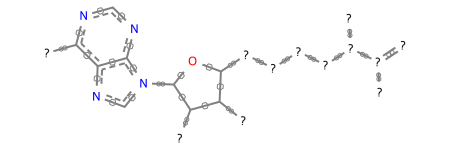

In [40]:
#SAM mcs corner case

print(known_reactions[19]['smi2name'])
smis = [
    'C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O',
    'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O'
]

mols = [Chem.MolFromSmiles(smi) for smi in smis]
print(mcs(mols))

from rdkit.Chem import rdFMCS

res = rdFMCS.FindMCS(
        mols,
        atomCompare=rdFMCS.AtomCompare.CompareElements,
        bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        matchChiralTag=False,
        ringMatchesRingOnly=True,
        completeRingsOnly=False,
        matchValences=False,
        timeout=10
    )
Chem.MolFromSmarts(res.smartsString)

In [41]:
foo = [1,1,2,3,4,4]
bar = set(foo)
baz = set(foo)
bar, baz

({1, 2, 3, 4}, {1, 2, 3, 4})